In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, mean_absolute_error, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression
import category_encoders as ce
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import RidgeClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
import seaborn as sns

%matplotlib inline

C:\Users\yeboa\AppData\Local\Temp\ipykernel_21344\3105957950.py:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [2]:
# read data
df = pd.read_csv('../data_files/train_data.csv')
df2 = pd.read_csv('../data_files/test_data.csv')

In [3]:
ids = df2['Customer Id']

In [4]:
df.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


### Changes

- Number of windows not dropped this time
- Insurance period no longer scaled

In [5]:
def replace_values(val):
    if val == '>=10':
        return 'greater than 10'
    elif val == '   .':
        return 'no data'
    elif int(val) < 5:
        return 'less than 5'
    else:
        return 'greater than 5'

In [6]:
def preprocess(df, filename):
    # drop ID col 
    df = df.drop('Customer Id', axis=1)

    
    # drop number of windows
    df['NumberOfWindows'] = df['NumberOfWindows'].apply(replace_values)
    
    
    # impute garden based on settlement
    df.loc[df.Settlement == 'U', 'Garden'] = 'V'
    df.loc[df.Settlement != 'U', 'Garden'] = 'O'
    
    
    # impute building dimension
    rural_dim = df[df['Settlement'] == 'R']
    rural_dim_mean = rural_dim["Building Dimension"].mean()
    urban_dim = df[df['Settlement'] == 'U']
    urban_dim_mean = urban_dim["Building Dimension"].mean()
    for i in range(len(df.Settlement)):
        if (df.Settlement[i] == 'U') and pd.isnull(df['Building Dimension'][i]):
            df.at[i, 'Building Dimension'] = urban_dim_mean
        elif (df.Settlement[i] == 'R') and pd.isnull(df['Building Dimension'][i]):
            df.at[i, 'Building Dimension'] = rural_dim_mean
        
        
    #replace occupancy NaN values with mode date
    date_mode = df.Date_of_Occupancy.mode()[0]
    df.Date_of_Occupancy.fillna(date_mode, inplace=True)
    df['Date_of_Occupancy'] = df['Date_of_Occupancy'].astype(int)
    
    
    # Convert the numerical values to string labels for building type
    mapping = {1: 'type1', 2: 'type2', 3: 'type3', 4: 'type4'}
    df['Building_Type'] = df['Building_Type'].map(mapping)
    
    # drop geo code
    df = df.drop('Geo_Code', axis=1)
    
    # save df
    df.to_csv(filename, index=False)

In [7]:
preprocess(df, '../data_files/train_clean2.csv')
preprocess(df2, '../data_files/test_clean2.csv')

In [8]:
df = pd.read_csv('../data_files/train_clean2.csv')
df2 = pd.read_csv('../data_files/test_clean2.csv')

In [9]:
df.head()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Claim
0,2013,1.0,0,N,V,V,U,290.0,type1,1960,no data,0
1,2015,1.0,0,V,N,O,R,490.0,type1,1850,less than 5,0
2,2014,1.0,0,N,V,V,U,595.0,type1,1960,no data,0
3,2013,1.0,0,V,V,V,U,2840.0,type1,1960,no data,0
4,2014,1.0,0,V,N,O,R,680.0,type1,1800,less than 5,0


In [10]:
cols_to_encode = ['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'Building_Type', 'NumberOfWindows']
# Perform one-hot encoding on cols
df2 = pd.get_dummies(df2, columns=cols_to_encode, prefix=cols_to_encode, drop_first=True)


df2['Occupancy_Period'] = df2['YearOfObservation'] - df2['Date_of_Occupancy']
df2 = df2.drop(columns=['YearOfObservation', 'Date_of_Occupancy'], axis=1)


# instantiate the scaler
scaler = StandardScaler()

# define columns to scale
cols_to_scale = ['Building Dimension', 'Occupancy_Period']

# fit and transform the training set
df2[cols_to_scale] = scaler.fit_transform(df2[cols_to_scale])

In [11]:
df2.head()

,Insured_Period,Residential,Building Dimension,Building_Painted_V,Building_Fenced_V,Garden_V,Settlement_U,Building_Type_type2,Building_Type_type3,Building_Type_type4,NumberOfWindows_greater than 5,NumberOfWindows_less than 5,NumberOfWindows_no data,Occupancy_Period
0,1.000000,0,-0.608342,1,0,0,0,0,0,0,0,1,0,0.205468
1,0.997268,0,-0.608342,1,0,0,0,0,0,0,0,1,0,0.340073
2,0.369863,0,-0.390181,1,1,1,1,0,0,0,0,0,1,0.205468
3,1.000000,0,-0.116367,1,0,0,0,0,0,0,0,1,0,-1.723872
4,1.000000,0,-0.116367,1,0,0,0,0,0,0,0,1,0,-1.634135


### Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Claim', axis=1), df['Claim'], test_size=0.2, random_state=42)  
X_train

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows
5266,2016,0.997268,1,N,V,V,U,850.000000,type4,1960,no data
5441,2015,1.000000,0,N,V,V,U,2135.000000,type2,1960,no data
7025,2013,1.000000,0,V,N,O,R,2700.000000,type3,1970,greater than 5
7130,2014,1.000000,1,V,V,V,U,1575.211611,type1,1700,no data
4454,2013,1.000000,0,V,N,O,R,1080.000000,type2,1960,greater than 5
...,...,...,...,...,...,...,...,...,...,...,...
3772,2015,1.000000,0,V,N,O,R,750.000000,type2,1990,greater than 5
5191,2013,1.000000,1,V,N,O,R,2670.000000,type4,1950,greater than 5
5226,2014,1.000000,1,V,N,O,R,2200.000000,type4,1904,greater than 5
5390,2012,1.000000,1,N,V,V,U,634.000000,type2,1960,no data


In [13]:
cols_to_encode = ['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'Building_Type', 'NumberOfWindows']

# Perform one-hot encoding on cols
X_train = pd.get_dummies(X_train, columns=cols_to_encode, prefix=cols_to_encode, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cols_to_encode, prefix=cols_to_encode, drop_first=True)
X_train.head()

,YearOfObservation,Insured_Period,Residential,Building Dimension,Date_of_Occupancy,Building_Painted_V,Building_Fenced_V,Garden_V,Settlement_U,Building_Type_type2,Building_Type_type3,Building_Type_type4,NumberOfWindows_greater than 5,NumberOfWindows_less than 5,NumberOfWindows_no data
5266,2016,0.997268,1,850.000000,1960,0,1,1,1,0,0,1,0,0,1
5441,2015,1.000000,0,2135.000000,1960,0,1,1,1,1,0,0,0,0,1
7025,2013,1.000000,0,2700.000000,1970,1,0,0,0,0,1,0,1,0,0
7130,2014,1.000000,1,1575.211611,1700,1,1,1,1,0,0,0,0,0,1
4454,2013,1.000000,0,1080.000000,1960,1,0,0,0,1,0,0,1,0,0


In [14]:
X_train['Occupancy_Period'] = X_train['YearOfObservation'] - X_train['Date_of_Occupancy']
X_test['Occupancy_Period'] = X_test['YearOfObservation'] - X_test['Date_of_Occupancy']
X_train = X_train.drop(columns=['YearOfObservation', 'Date_of_Occupancy'], axis=1)
X_test = X_test.drop(columns=['YearOfObservation', 'Date_of_Occupancy'], axis=1)

In [15]:
def analyze_results(final_model, X_test, y_pred):
    # Predict the probabilities of the test set
    y_prob = final_model.predict_proba(X_test)[:, 1]

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.colorbar()
    
    # Add the number of values in each cell of the confusion matrix
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment='center',
                     verticalalignment='center')
            
    plt.title('Confusion matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.yticks([0, 1], ['Negative', 'Positive'])
    plt.show()

    # Compute the ROC curve and ROC AUC score
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
#     plt.plot(fpr, tpr, lw=1, label='ROC (AUC = %0.2f)' % (roc_auc))
#     plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
#     plt.xlim([-0.05, 1.05])
#     plt.ylim([-0.05, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic (ROC) Curve')
#     plt.legend(loc="lower right")
#     plt.show()

In [16]:
def train_xgboost_model(X_train, y_train, X_test, output_file, df_test):
    # Define the XGBoost model
    xgb_model = XGBClassifier()

    # Define the parameter grid to search over
    params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.5]
    }

    # Define the grid search object
    grid_search = GridSearchCV(
        estimator=xgb_model, 
        param_grid=params, 
        scoring='roc_auc', 
        cv=5, 
#         refit='roc_auc', 
        n_jobs=-1
    )

    # Fit the grid search object to the data
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Train an XGBoost model with the best parameters
    xgb_model_best = XGBClassifier(**best_params)
    xgb_model_best.fit(X_train, y_train)

    # Predict the test set
    y_pred = xgb_model_best.predict(X_test)
    submission_pred = xgb_model_best.predict(df_test) 
    results = pd.DataFrame(list(zip(ids, submission_pred)), columns=['Customer Id', 'Claim'])
    results.to_csv(output_file, index=False)
    
    # Print the best parameters and best score
    print('Best parameters: ', best_params)
    print('Best score: ', best_score)
    
    # Print the classification report
    print(classification_report(y_test, y_pred))

    # Print the roc_score report   
    print(f'ROC_AUC_SCORE: {roc_auc_score(y_test, y_pred)}')
    
    analyze_results(xgb_model_best, X_test, y_pred)

In [24]:
def train_gradient_boosting_model(X_train, y_train, X_test, output_file, df_test):
    # Define the parameter grid to search over
    param_grid = {'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 10, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2', None]}

    # Create a GradientBoostingClassifier
    gbc = GradientBoostingClassifier(random_state=42)

    # Create a GridSearchCV object
    grid_search = GridSearchCV(
        estimator=gbc, 
        param_grid=param_grid, 
        cv=5, 
        n_jobs=-1, 
        verbose=1, 
        scoring='roc_auc')

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters and the corresponding score
    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

    # Use the best hyperparameters to create a final model
    final_model = GradientBoostingClassifier(**grid_search.best_params_, random_state=42)

    # Fit the final model to the data
    final_model.fit(X_train, y_train)

    # Predict the labels of the test set
    y_pred = final_model.predict(X_test)
    submission_pred = final_model.predict(df_test) 
    results = pd.DataFrame(list(zip(ids, submission_pred)), columns=['Customer Id', 'Claim'])
    results.to_csv(output_file, index=False)

    # Print the classification report
    print(classification_report(y_test, y_pred))
    
    # Print the roc_score report    
    print(f'ROC_AUC_SCORE: {roc_auc_score(y_test, y_pred)}')
    
    analyze_results(final_model, X_test, y_pred)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best score:  0.717421617159288
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      1098
           1       0.61      0.17      0.27       334

    accuracy                           0.78      1432
   macro avg       0.70      0.57      0.57      1432
weighted avg       0.75      0.78      0.73      1432

ROC_AUC_SCORE: 0.5689358986944144


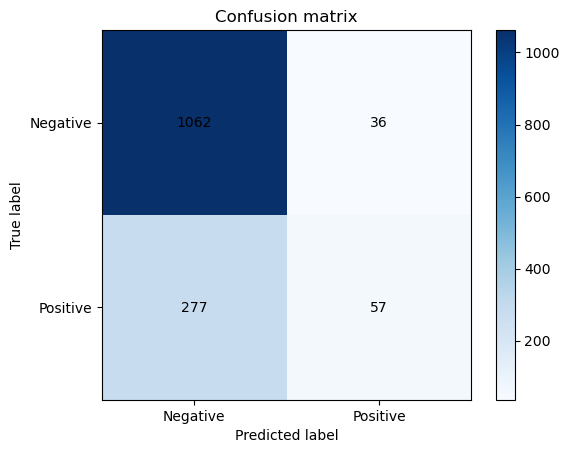

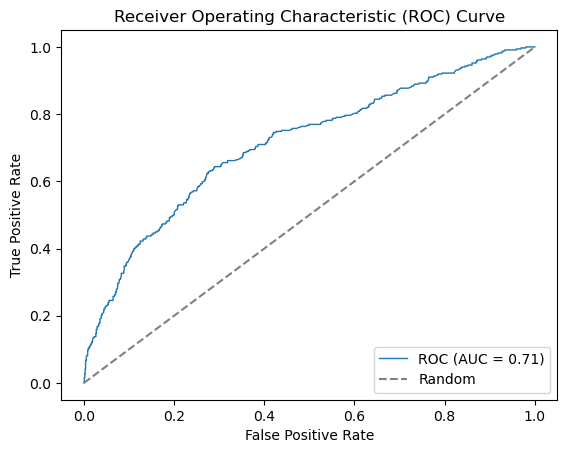

In [22]:
train_xgboost_model(X_train, y_train, X_test, 'xgboost_m2.txt', df2)

In [18]:
# Instantiate SMOTE
sm = SMOTE(random_state=42)

# Fit and transform the data
X_train_sm_resampled, y_train_sm_resampled = sm.fit_resample(X_train, y_train)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Best score:  0.883916773205768
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1098
           1       0.41      0.31      0.36       334

    accuracy                           0.74      1432
   macro avg       0.61      0.59      0.60      1432
weighted avg       0.71      0.74      0.72      1432

ROC_AUC_SCORE: 0.5893349912197463


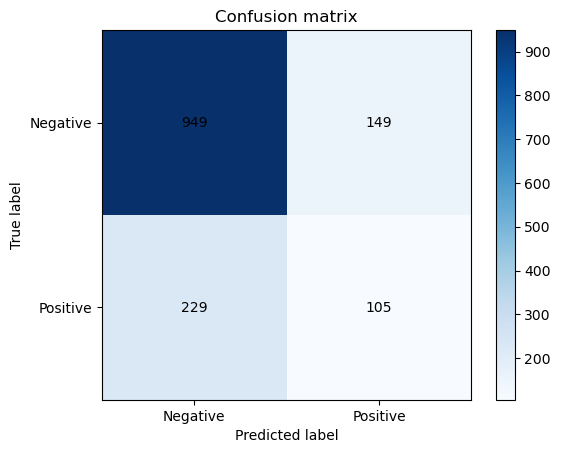

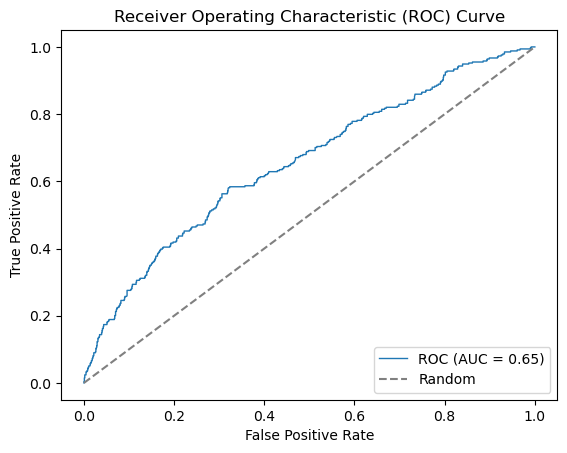

In [25]:
train_xgboost_model(X_train_sm_resampled, y_train_sm_resampled, X_test, 'xgboost_m2_smote.txt', df2)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best score:  0.8938831496582818
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1098
           1       0.41      0.34      0.37       334

    accuracy                           0.73      1432
   macro avg       0.61      0.60      0.60      1432
weighted avg       0.72      0.73      0.72      1432

ROC_AUC_SCORE: 0.5956529563823173


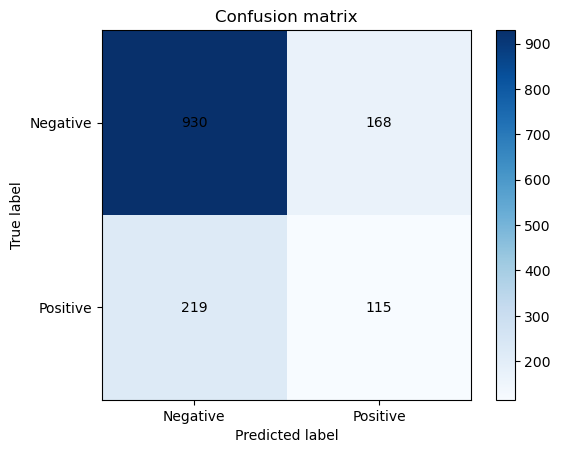

In [23]:
train_gradient_boosting_model(X_train_sm_resampled, y_train_sm_resampled, X_test, '../submissions/gradientboost_m2_smote.csv', df2)

### Utilizing TabNet Deep Learning Model

In [ ]:
def train_TabNet(df):
    # Split the data into training and validation sets
    train_data = df.sample(frac=0.8, random_state=42)
    val_data = df.drop(train_data.index)

    # Define the columns to use as input features and target
    cat_cols = ["categorical_feature1", "categorical_feature2"]
    num_cols = ["numerical_feature1", "numerical_feature2"]
    target_col = "target"

    # Initialize the TabNet model with default parameters
    tabnet_model = TabNetClassifier(cat_cols=cat_cols, num_cols=num_cols, 
                                    output_dim=2, optimizer_fn=torch.optim.Adam, 
                                    optimizer_params=dict(lr=2e-2), 
                                    scheduler_params={"step_size":10, "gamma":0.9},
                                    scheduler_fn=torch.optim.lr_scheduler.StepLR)

    # Train the model on the training data
    tabnet_model.fit(X_train=train_data.drop(target_col, axis=1).values, y_train=train_data[target_col].values,
                     eval_set=[(val_data.drop(target_col, axis=1).values, val_data[target_col].values)],
                     max_epochs=50, patience=20)

    # Plot the training loss
    if hasattr(tabnet_model, 'history'):
        plt.plot(tabnet_model.history['train']['loss'], label='Train Loss')
        plt.plot(tabnet_model.history['valid']['loss'], label='Valid Loss')
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    # Use the model to make predictions on new data
    val_preds = tabnet_model.predict(val_data.drop(target_col, axis=1).values)
    
    # Calculate classification metrics
    val_acc = accuracy_score(val_data[target_col], val_preds)
    val_precision = precision_score(val_data[target_col], val_preds)
    val_recall = recall_score(val_data[target_col], val_preds)
    val_f1 = f1_score(val_data[target_col], val_preds)
    val_roc_auc = roc_auc_score(val_data[target_col], tabnet_model.predict_proba(val_data.drop(target_col, axis=1).values)[:, 1])

    # Print the metrics
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1 score: {val_f1:.4f}")
    print(f"Validation AUC-ROC score: {val_roc_auc:.4f}")

    # Generate a confusion matrix heatmap
    conf_mat = confusion_matrix(val_data[target_col].values, val_preds)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [ ]:
# Calculate class weights
class_counts = train_data[target_col].value_counts()
class_weights = {0: 1 / class_counts[0], 1: 1 / class_counts[1]}

# Initialize the TabNet model with class weights
tabnet_model = TabNetClassifier(cat_cols=cat_cols, num_cols=num_cols, 
                                output_dim=2, optimizer_fn=torch.optim.Adam, 
                                optimizer_params=dict(lr=2e-2), 
                                scheduler_params={"step_size":10, "gamma":0.9},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                class_weight=class_weights)

In [ ]:
# Use the model to make predictions on new data
val_probs = tabnet_model.predict_proba(val_data.drop(target_col, axis=1).values)

# Set the decision threshold to 0.7
decision_threshold = 0.7

# Convert the probabilities to binary labels using the decision threshold
val_preds = (val_probs[:, 1] >= decision_threshold).astype(int)
